In [84]:
import xarray as xr
import rioxarray
import glob
import os
import numpy as np
import requests
import geopandas as gpd
from pathlib import Path

def open_rasterio_lsr(path, band_int = False):
    """Reads in a Landsat surface reflectance band and correctly assigns the band metadata.
    
    For raw Landsat 8 sr bands, it goes band 1, 2, 3, 4, 5, 6, 7 and the 8th band is pixel qa. 
    For et, the fourth is eta, etf, etqa, etun, pixel_qa.
    Args:
        path (str): Path of form 
            .../LT05_L1TP_032031_20050406_20160912_01_T1_sr_band5.tif.
    Returns:
        bool: Returns an xarray data array
    """
    if band_int:
        band_int = band_int
    else:
        if "pixel_qa" in str(path):
            band_int = 8
        else:
            band_int = int(os.path.splitext(path)[0][-1])

    data_array = rioxarray.open_rasterio(path, chunks={'band': 1}) #chunks makes i lazyily executed
    data_array = data_array.sel(band=1).drop("band") # gets rid of old coordinate dimension since we need bands to have unique coord ids
    data_array["band"] = band_int # makes a new coordinate
    data_array = data_array.expand_dims({"band":1}) # makes this coordinate a dimension
    return data_array

def read_bands_lsr(scene_folder, pattern='*sr_band*', set_band_int=False):
    """
    Concatenates a list of landsat paths into a single data array. also returns et as final band.
    
    Args:
        path_list (str): Paths of form 
            .../LT05_L1TP_032031_20050406_20160912_01_T1_sr_band5.tif or 
            ARD format
            LT05_CU_012007_20050515_20190108_C01_V01_SRB5.tif
            in a list.
    Returns:
        bool: Returns an xarray data array
    """
    sr_paths = sorted(Path(scene_folder).glob(pattern))
    qa_path = list(Path(scene_folder).glob("*pixel_qa.tif"))[0]
    sr_paths.append(qa_path)
    if set_band_int:
        band_arrs = [open_rasterio_lsr(path, band_int=i+1) for i, path in enumerate(sr_paths)]
    else:
        band_arrs = [open_rasterio_lsr(path) for path in sr_paths]
    return xr.concat(band_arrs, dim="band")

def read_scenes(all_scene_folder):
    """
    Reads in multiple Landsat surface reflectance scenes given a regex pattern for ARD scene folders.
    Args:
        path (str): Path of form "../*".
    Returns:
        list: Returns a list of xarray data arrays
    """
    # only select files that contain a band
    scene_folders = sorted(Path(all_scene_folder).glob('L*'))
    xr_arrs = [read_bands_lsr(folder) for folder in scene_folders]
    return xr_arrs


In [93]:
all_scenes_f = '/home/rave/serdp/dangermond-sb/landsat-sr-et/'

In [94]:
testf = Path(all_scenes_f) / 'LC080420362019072401T1-SC20201106225918'

print(list(testf.glob("*et*")))

read_bands_lsr(testf)

print(sorted(Path(testf).glob("*sr_band*")))

et = read_bands_lsr(testf, pattern="*_et*", set_band_int=True)

[PosixPath('/home/rave/serdp/dangermond-sb/landsat-sr-et/LC080420362019072401T1-SC20201106225918/LC08_L1TP_042036_20190724_20190801_01_T1_eta.tif'), PosixPath('/home/rave/serdp/dangermond-sb/landsat-sr-et/LC080420362019072401T1-SC20201106225918/LC08_L1TP_042036_20190724_20190801_01_T1_etf.tif'), PosixPath('/home/rave/serdp/dangermond-sb/landsat-sr-et/LC080420362019072401T1-SC20201106225918/LC08_L1TP_042036_20190724_20190801_01_T1_etun.tif'), PosixPath('/home/rave/serdp/dangermond-sb/landsat-sr-et/LC080420362019072401T1-SC20201106225918/LC08_L1TP_042036_20190724_20190801_01_T1_etqa.tif')]
[PosixPath('/home/rave/serdp/dangermond-sb/landsat-sr-et/LC080420362019072401T1-SC20201106225918/LC08_L1TP_042036_20190724_20190801_01_T1_sr_band1.tif'), PosixPath('/home/rave/serdp/dangermond-sb/landsat-sr-et/LC080420362019072401T1-SC20201106225918/LC08_L1TP_042036_20190724_20190801_01_T1_sr_band2.tif'), PosixPath('/home/rave/serdp/dangermond-sb/landsat-sr-et/LC080420362019072401T1-SC20201106225918/LC

In [99]:
et.sel(band=1).attrs

{'transform': (30.0, 0.0, 122685.0, 0.0, -30.0, 3952515.0),
 '_FillValue': -9999.0,
 'scale_factor': 1.0,
 'add_offset': 0.0,
 'long_name': 'Evapotranspiration actual',
 'grid_mapping': 'spatial_ref'}

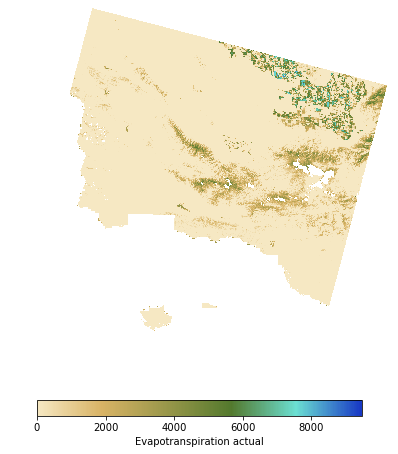

In [104]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
%matplotlib inline

ETcolors = ["#f6e8c3", "#d8b365", "#99974a", "#53792d", "#6bdfd2", "#1839c5"]
ETcmap = LinearSegmentedColormap.from_list("ET", ETcolors)
# date_utc = pd.to_datetime(et['date'].values)
# layer_type = et.attrs['filename'].split("_")[-3]
title = 'Provisional ET Santa Barnara and Dangermond'

fig = plt.figure(figsize=(9.7,7.6))                                                       # Set the figure size (x,y)
# fig.suptitle(f'{title} ({layer_type}) \n at {date_utc}', fontsize=22)  # Add title for the plots
plt.axis('off')                                                                           # Remove axes from plot
im = plt.imshow(et.sel(band=1).where(et.sel(band=1)!= -9999.)  , cmap=ETcmap);                                                        # Plot array using colormap
# plt.scatter(Tcol, Trow, color="black", marker='x')                                       
# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.004, label=f"{et.attrs['long_name']}", shrink=0.6).outline.set_visible(True)
plt.savefig("./testet.png", dpi=600)